# Qiskit Gradient Framework using Primitives
This tutorial demonstrates the use of the `qiskit.algorithms.gradients` module to evaluate quantum gradients using the [Qiskit Primitives](https://qiskit.org/documentation/apidoc/primitives.html).

## Introduction
The gradient frameworks allows the evaluation of quantum gradients.
Besides gradients of expectation values of the form
$$ \langle\psi\left(\theta\right)|\hat{O}\left(\omega\right)|\psi\left(\theta\right)\rangle $$
and sampling probabilities of the form
$$p_j(\theta) = |\langle j | \psi(\theta)\rangle|^2$$
the gradient frameworks also support the evaluation of the Quantum Geometric Tensor (QGT) and Quantum Fisher Information (QFI) of quantum states $|\psi\left(\theta\right)\rangle$.

## A quick refresher on Qiskit Primitives

The Qiskit Primitives work as an abstraction level between algorithms and (real/simulated) quantum devices. Instead of having to manually deal with tasks such as parameter binding or circuit transpilation, the `primitives` module offers a `Sampler` and an `Estimator` class that take the circuits, the observable Hamiltonians, and the circuit parameters and return the sampling distribution and the computed expectation values respectively.

`qiskit.primitives` provides two classes for evaluating the circuit:
- The `Estimator` class allows to evaluate expectation values of observables with respect to states prepared by quantum circuits.
- The `Sampler` class returns quasi-probability distributions as a result of sampling quantum circuits.

## The `algorithms.gradients` Framework

The `algorithms.gradients` module contains tools to compute both circuit gradients and circuit metrics. The gradients extend the `BaseEstimatorGradient` and `BaseSamplerGradient` base classes. These are abstract classes on top of which different gradient methods have been implemented. The methods currently available in this module are:
- Parameter Shift Gradients
- Finite Difference Gradients
- Linear Combination of Unitaries Gradients
- Simultaneous Perturbation Stochastic Approximation (SPSA) Gradients

Additionally, the module offers reverse gradients for efficient classical computations.

The metrics available are based on the notion of the Quantum Geometric Tensor (QGT). There is a `BaseQGT` class (`Estimator`-based) on top of which different QGT methods have been implemented:
- Linear Comination of Unitaries QGT
- Reverse QGT (classical)
As well as a Quantum Fisher Information class (QFI) that is initialized with a reference QGT implementation from the above list.

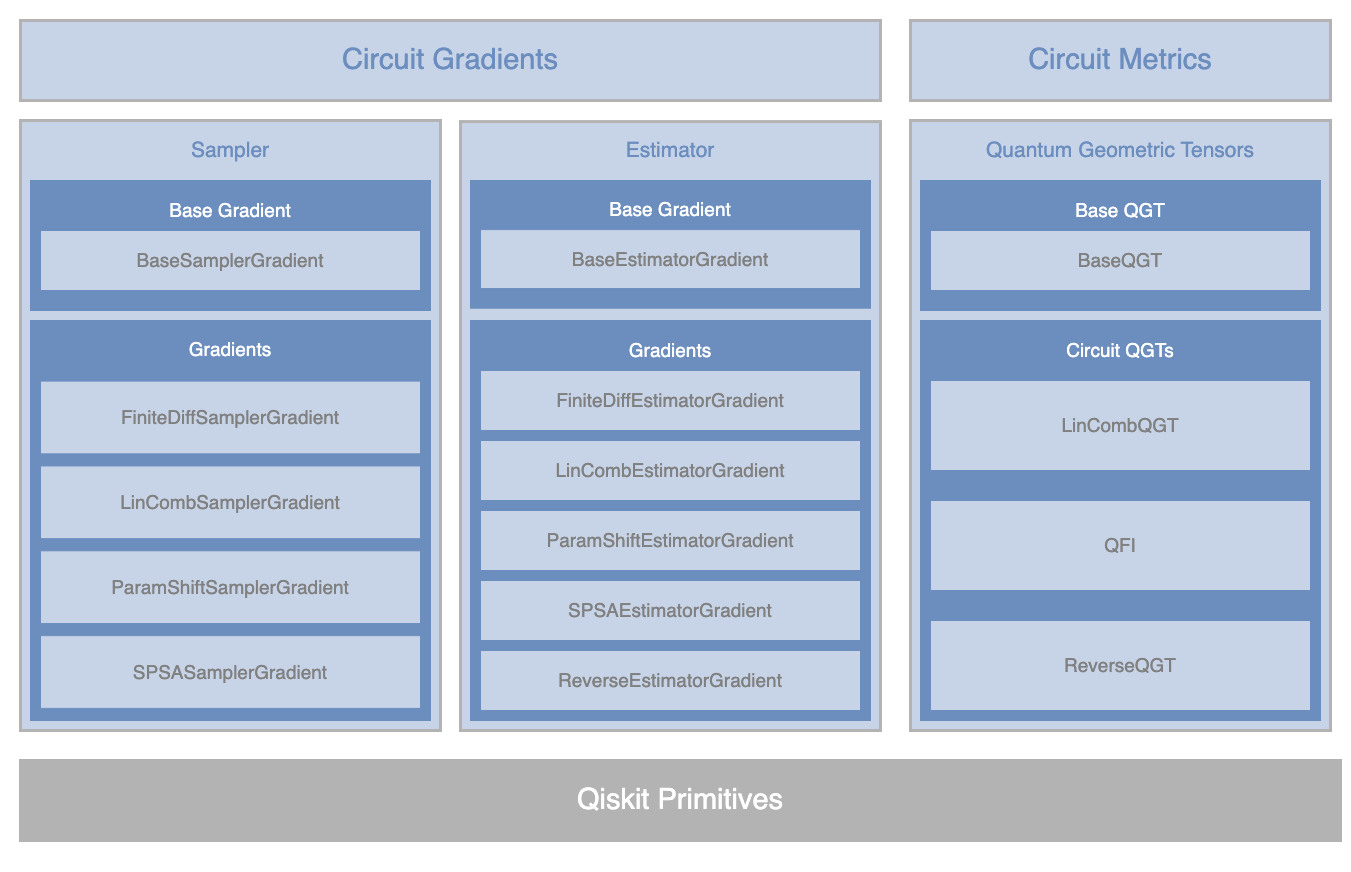

<center>The outline of the <code>qiskit.algorithms.gradients</code> framework </center>

## Gradients


Given a parameterized quantum state $|\psi\left(\theta\right)\rangle = V\left(\theta\right)|\psi\rangle$ with input state $|\psi\rangle$, , we want to compute either its expectation gradient $\langle\psi\left(\theta\right)|\hat{O}\left(\omega\right)|\psi\left(\theta\right)\rangle$ or the gradient of the sampling probability $p_j(\theta) = |\langle j | \psi(\theta)\rangle|^2$

### Sampling gradients
The formula for the gradient of sampling is:

$$\frac{\partial}{\partial \theta} p_j(\theta) = \frac{\partial}{\partial \theta} |\langle j | \psi(\theta)\rangle|^2 $$

Thus, the output of the sampler gradient is a list of dictionaries, where each dictionary has entries for different values of $j$ in the formula above:

```
[{d/d theta_1 p_1: .., d/d theta_1 p_2, ..,}, {d/d theta_2 p_1: .., d/d theta_2 p_2, ..}, ..]
```

### Expectation gradients
The formula for expectation gradient is:

$$\frac{\partial}{\partial \theta} \langle E \rangle = \frac{\partial}{\partial \theta} \langle\psi\left(\theta\right)|\hat{O}\left(\omega\right)|\psi\left(\theta\right)\rangle $$

Thus, the output format of the estimator gradient is a list of derivatives:
```
[d/d theta_1 <E>, d/d theta_2 <E>, ...]
```

## Gradient Evaluation of Quantum Circuits 
- Let's say that we want to use one of our `Estimator` gradients classes, then we need a quantum state $\vert\psi(\theta)\rangle$ and a Hamiltonian H acting as an observable. For the Sampler gradients, we just need a quantum state.

- We then construct a list of the parameters for which we aim to evaluate the gradient.

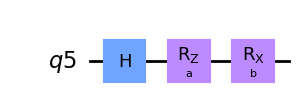

In [65]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
from qiskit.quantum_info import SparsePauliOp
import numpy as np

#Instantiate the quantum circuit
a = Parameter('a')
b = Parameter('b')
q = QuantumRegister(1)
qc = QuantumCircuit(q)
qc.h(q)
qc.rz(a, q[0])
qc.rx(b, q[0])

display(qc.draw('mpl'))

#Instantiate the Hamiltonian observable 2X+Z
H = SparsePauliOp.from_list([('X', 2), ('Z',1)])

#Parameter list
params = [[np.pi / 4, 0]]

We can now choose a gradient type to evaluate the gradient of the circuit ansatz.

### Parameter Shift Gradients

#### Using Estimator
Given a Hermitian operator $g$ with two unique eigenvalues $\pm r$ which acts as generator for a parameterized quantum gate $$G(\theta)= e^{-i\theta g}.$$
Then, quantum gradients can be computed by using eigenvalue $r$ dependent shifts to parameters. 
All [standard, parameterized Qiskit gates](https://github.com/Qiskit/qiskit-terra/tree/master/qiskit/circuit/library/standard_gates) can be shifted with $\pi/2$, i.e.,
 $$ \frac{\partial\langle\psi\left(\theta\right)|\hat{O}\left(\omega\right)|\psi\left(\theta\right)\rangle}{\partial\theta} =  
 \frac{\langle\psi\left(\theta+\pi/2\right)|\hat{O}\left(\omega\right)|\psi\left(\theta+\pi/2\right)\rangle -\langle\psi\left(\theta-\pi/2\right)|\hat{O}\left(\omega\right)|\psi\left(\theta-\pi/2\right)\rangle }{ 2}.$$

In [73]:
from qiskit.primitives import Estimator
from qiskit.algorithms.gradients import ParamShiftEstimatorGradient

#Define the estimator
estimator = Estimator()
#Define the gradient
gradient = ParamShiftEstimatorGradient(estimator)

# Evaluate the gradient of the circuits using parameter shift gradients
pse_grad_result = gradient.run(qc, H,  params).result().gradients

print('State estimator gradient computed with parameter shift', pse_grad_result)

State gradient computed with parameter shift [array([-1.41421356,  0.70710678])]


#### Using Sampler

Following a similar logic to the estimator gradient, when we have a quantum state prepared by a quantum circuit, we can shift the parametrized gates by $\pm \pi/2$ and sample to compute the gradient of the sampling probability.

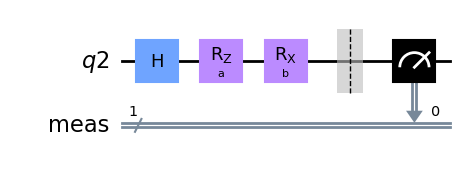

In [62]:
# Instantiate the quantum state with two parameters
a = Parameter('a')
b = Parameter('b')

q = QuantumRegister(1)
qc_sample = QuantumCircuit(q)
qc_sample.h(q)
qc_sample.rz(a, q[0])
qc_sample.rx(b, q[0])
qc_sample.measure_all() #important for sampler

qc_sample.draw('mpl')

In [60]:
from qiskit.primitives import Sampler
from qiskit.algorithms.gradients import ParamShiftSamplerGradient

param_vals = [[np.pi/4, np.pi/2]]
sampler = Sampler()
gradient = ParamShiftSamplerGradient(sampler)
pss_grad_result = gradient.run(qc_sample, param_vals).result().gradients
print('State sampler gradient computed with parameter shift', pss_grad_result)

[[{0: 0.35355339059327373, 1: -0.3535533905932736}, {0: 0.0, 1: 0.0}]]


> **Note:** All the following methods in this tutorial are explained using the `Estimator` class to evaluate the gradients, but, in an analogous way to the Parameter Shift gradients just introduced, the method explanation can also be applied to `Sampler`-based gradients. Both versions are available in `algorithms.gradients`.

### Linear Combination of Unitaries Gradients
Unitaries can be written as $U\left(\omega\right) = e^{iM\left(\omega\right)}$, where $M\left(\omega\right)$ denotes a parameterized Hermitian matrix. 
Further, Hermitian matrices can be decomposed into weighted sums of Pauli terms, i.e., $M\left(\omega\right) = \sum_pm_p\left(\omega\right)h_p$ with $m_p\left(\omega\right)\in\mathbb{R}$ and $h_p=\bigotimes\limits_{j=0}^{n-1}\sigma_{j, p}$ for $\sigma_{j, p}\in\left\{I, X, Y, Z\right\}$ acting on the $j^{\text{th}}$ qubit. Thus, the gradients of 
$U_k\left(\omega_k\right)$ are given by
\begin{equation*}
\frac{\partial U_k\left(\omega_k\right)}{\partial\omega_k} = \sum\limits_pi \frac{\partial m_{k,p}\left(\omega_k\right)}{\partial\omega_k}U_k\left(\omega_k\right)h_{k_p}.
\end{equation*}

Combining this observation with a circuit structure presented in [Simulating physical phenomena by quantum networks](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.65.042323) allows us to compute the gradient with the evaluation of a single quantum circuit.

In [74]:
from qiskit.algorithms.gradients import LinCombEstimatorGradient

# Evaluate the gradient of the circuits using linear combination of unitaries
state_grad = LinCombEstimatorGradient(estimator)

# Evaluate the gradient
lce_grad_result = state_grad.run(qc, H, params).result().gradients
print('State estimator gradient computed with the linear combination method', lce_grad_result)

State gradient computed with the linear combination method [array([-1.41421356,  0.70710678])]


### Finite Difference Gradients

Unlike the other methods, finite difference gradients are numerical estimations rather than analytical values.
This implementation employs a central difference approach with $\epsilon \ll 1$
$$ \frac{\partial\langle\psi\left(\theta\right)|\hat{O}\left(\omega\right)|\psi\left(\theta\right)\rangle}{\partial\theta} \approx \frac{1}{2\epsilon} \left(\langle\psi\left(\theta+\epsilon\right)|\hat{O}\left(\omega\right)|\psi\left(\theta+\epsilon\right)\rangle - \partial\langle\psi\left(\theta-\epsilon\right)|\hat{O}\left(\omega\right)|\psi\left(\theta-\epsilon\right)\rangle\right).$$
 Probability gradients are computed equivalently.

In [75]:
from qiskit.algorithms.gradients import FiniteDiffEstimatorGradient

state_grad = FiniteDiffEstimatorGradient(estimator, epsilon = 0.001)

# Evaluate the gradient
fde_grad_result = state_grad.run(qc, H, params).result().gradients
print('State estimator gradient computed with finite difference', fde_grad_result)

State gradient computed with finite difference [array([-1.41421333,  0.70710666])]


### SPSA Gradients

SPSA gradients compute the gradients of the expectation value by the [Simultaneous Perturbation Stochastic Approximation (SPSA) algorithm](https://ieeexplore.ieee.org/document/880982). `epsilon` is the amount of offset, `batch_size` is the number of times the circuit is executed to estimate the gradient. As SPSA is a random process, use the `seed` value to avoid randomization.

In [70]:
from qiskit.algorithms.gradients import SPSAEstimatorGradient

state_grad = SPSAEstimatorGradient(estimator, epsilon = 0.001, batch_size=10, seed=50)

# Evaluate the gradient
spsae_grad_result = state_grad.run(qc, H, params).result().gradients
print('State estimator gradient computed with SPSA:', spsae_grad_result)

State gradient computed with SPSA: [array([-1.41421333,  0.70710631])]


## Circuit Quantum Geometric Tensors (QGTs)
QGT is a metric in geometric quantum computing and can be regarded as a metric measuring the geodesic distance of points lying on the Bloch sphere. Its real and imaginary parts give different informations about the quantum state. 

The entries of the QGT for a pure state is given by

$$QGT_{kl}(\theta) = \langle\partial_k\psi(\theta)|\partial_l\psi(\theta)\rangle-\langle\partial_k\psi(\theta)|\psi(\theta)\rangle\langle\psi(\theta)|\partial_l\psi(\theta)\rangle.$$ 

### Linear Combination QGT
This method employs a linear combination of unitaries, as explained in the **Gradients** section.

In [71]:
from qiskit.algorithms.gradients import DerivativeType, LinCombQGT

qgt = LinCombQGT(estimator, derivative_type=DerivativeType.COMPLEX)

param_vals = [[np.pi/4, 0.1]]

#Evaluate the QGTs
qgt_result = qgt.run(qc, param_vals).result().qgts
print('QGT:')
print(qgt_result)

QGT:
[array([[ 2.50000000e-01+7.54884100e-19j, -3.75686535e-17+1.76776695e-01j],
       [-3.75686535e-17-1.76776695e-01j,  1.25000000e-01-7.54884100e-19j]])]


### Quantum Fisher Information (QFI)

The Quantum Fisher Information is a metric tensor which is representative for the representation capacity of a 
parameterized quantum state $|\psi\left(\theta\right)\rangle = V\left(\theta\right)|\psi\rangle$ with input state $|\psi\rangle$, parametrized Ansatz $V\left(\theta\right)$.

The QFI can thus be evaluated from QGT as

$$
\begin{align*}
QFI_{kl} &= 4 * \text{Re}(QGT_{kl}) \\
         &=4 *\text{Re}\left[\langle\partial_k\psi|\partial_l\psi\rangle-\langle\partial_k\psi|\psi\rangle\langle\psi|\partial_l\psi\rangle \right].
\end{align*}$$

In [72]:
from qiskit.algorithms.gradients import QFI

#Define the QFI metric for the QGT
qfi = QFI(qgt)

# Evaluate the QFI
qfi_result = qfi.run(qc, param_vals).result().qfis
print('QFI:')
print(qfi_result)

QFI:
[array([[ 1.00000000e+00, -1.50274614e-16],
       [-1.50274614e-16,  5.00000000e-01]])]


## Application Example: VQE with gradient-based optimization

### Estimator

Let's see an application of these gradient classes in a gradient-based optimization. We will use the Variational Quantum Eigensolver (VQE) algorith. First, the Hamiltonian and wavefunction ansatz are initialized.

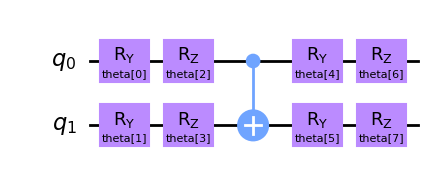

In [61]:
from qiskit.circuit import ParameterVector

# Instantiate the system Hamiltonian
h2_hamiltonian = SparsePauliOp.from_list([('II', -1.05), 
                                          ('IZ',  0.39), 
                                          ('ZI', -0.39), 
                                          ('ZZ', -0.01)])

# This is the target energy
h2_energy = -1.85727503

# Define the Ansatz
wavefunction = QuantumCircuit(2)
params = ParameterVector('theta', length=8)
it = iter(params)
wavefunction.ry(next(it), 0)
wavefunction.ry(next(it), 1)
wavefunction.rz(next(it), 0)
wavefunction.rz(next(it), 1)
wavefunction.cx(0, 1)
wavefunction.ry(next(it), 0)
wavefunction.ry(next(it), 1)
wavefunction.rz(next(it), 0)
wavefunction.rz(next(it), 1)

wavefunction.draw('mpl')

In [48]:
#Make circuit copies for different VQEs
wavefunction_1 = wavefunction.copy()
wavefunction_2 = wavefunction.copy()

The `VQE` will take an `Estimator`, the ansatz and optimizer, and an optional gradient. We will use the `LinCombEstimatorGradient` gradient to compute the VQE.

In [55]:
from qiskit.algorithms.optimizers import CG
from qiskit.algorithms.minimum_eigensolvers import VQE, SamplingVQE

#Conjugate Gradient algorithm
optimizer = CG(maxiter=50)

# Gradient callable
estimator = Estimator()
grad = LinCombEstimatorGradient(estimator) # optional estimator gradient
vqe = VQE(estimator=estimator, ansatz=wavefunction, optimizer=optimizer, gradient=grad)

result = vqe.compute_minimum_eigenvalue(h2_hamiltonian)
print('Result of Estimator VQE:', result.optimal_value, '\nReference:', h2_energy)

Result of Estimator VQE: -1.8199999998468706 
Reference: -1.85727503


### Classical Optimizer

We can also use a classical optimizer to optimize the VQE. We'll use the `minimize` function from SciPy. 

In [52]:
from scipy.optimize import minimize

#Classical optimizer
vqe_classical = VQE(estimator=estimator, ansatz=wavefunction_2, optimizer=minimize, gradient=grad)

result_classical = vqe_classical.compute_minimum_eigenvalue(h2_hamiltonian)
print('Result of classical optimizer:', result_classical.optimal_value, '\nReference:', h2_energy)

Result of classical optimizer: -1.8199999999831082 
Reference: -1.85727503


In [53]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright